In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

In [2]:
# Load the data
dt = pd.read_csv('../../data/processed_data_1.csv')
print(dt.head())

# Prepare the features and target
X = dt.drop(['price_in_USD'], axis='columns')
Y = dt['price_in_USD']

   bhk  type  locality  area  region  status  age  price_in_USD
0    3     0      3019   685       8       0    0      300000.0
1    2     0      4965   640     124       1    0       63012.0
2    2     0      7031   610      31       1    0      207600.0
3    2     0      8484   876     140       1    0       71976.0
4    2     0      4288   659     117       1    0      112932.0


In [3]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_k, X_val, Y_k, Y_val = train_test_split(X, Y, test_size=0.3, random_state=10)

In [4]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [5]:
# Train an Elastic Net model with cross-validation to find the best alpha and l1_ratio
reg_elasticnet_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X_train_scaled, Y_train)

# Print the best alpha and l1_ratio found by ElasticNetCV
print(f"Best alpha: {reg_elasticnet_cv.alpha_}")
print(f"Best l1_ratio: {reg_elasticnet_cv.l1_ratio_}")

Best alpha: 196.03648624763562
Best l1_ratio: 1.0


In [6]:
# Get the best alpha and l1_ratio
best_alpha = reg_elasticnet_cv.alpha_
best_l1_ratio = reg_elasticnet_cv.l1_ratio_
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

Best alpha: 196.03648624763562
Best l1_ratio: 1.0


In [7]:
# Initialize the Elastic Net model with the best alpha and l1_ratio
reg_elasticnet = ElasticNet(alpha=reg_elasticnet_cv.alpha_, l1_ratio=reg_elasticnet_cv.l1_ratio_)
reg_elasticnet.fit(X_train_scaled, Y_train)

ElasticNet(alpha=196.03648624763562, l1_ratio=1.0)

In [8]:
# Evaluate the model on the test set
score = reg_elasticnet.score(X_test_scaled, Y_test)
print("R-squared on the test set:", score)

R-squared on the test set: 0.599117513425174


In [9]:
# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    reg_elasticnet, X_train_scaled, Y_train, cv=4, train_sizes=np.linspace(0.1, 1.0, 10), scoring="r2"
)


In [10]:
# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Print the training scores and cross-validation scores
print("Training scores:\n", train_scores)
print("Cross-validation scores:\n", val_scores)

# Print the mean and standard deviation of training and cross-validation scores
print("Mean training scores:\n", train_scores_mean)
print("Mean cross-validation scores:\n", val_scores_mean)

Training scores:
 [[0.56130993 0.57202306 0.57202306 0.57202306]
 [0.58887933 0.56351926 0.56351926 0.56351926]
 [0.61481739 0.57203157 0.57203157 0.57203157]
 [0.61690605 0.58636203 0.57403298 0.57403298]
 [0.61708734 0.59281537 0.57854172 0.57854172]
 [0.61173312 0.5913041  0.58991857 0.58991857]
 [0.60620118 0.58851584 0.59010348 0.59435375]
 [0.60572802 0.59037964 0.59152241 0.5991482 ]
 [0.60348729 0.58958129 0.59084313 0.59927351]
 [0.60380225 0.59114288 0.59249933 0.59730761]]
Cross-validation scores:
 [[0.5703999  0.60872358 0.60422844 0.58961261]
 [0.57176645 0.60983294 0.60546716 0.59255177]
 [0.57196756 0.60998992 0.60510544 0.59317078]
 [0.57190417 0.61029294 0.60602439 0.59277314]
 [0.57162151 0.61038728 0.6055411  0.59306837]
 [0.57193476 0.61041323 0.60585285 0.59277509]
 [0.57173551 0.61052152 0.60571036 0.59268339]
 [0.57107229 0.61043928 0.60655262 0.59178884]
 [0.57197541 0.61049224 0.60592657 0.59186634]
 [0.572468   0.61039785 0.60516141 0.59176136]]
Mean training 

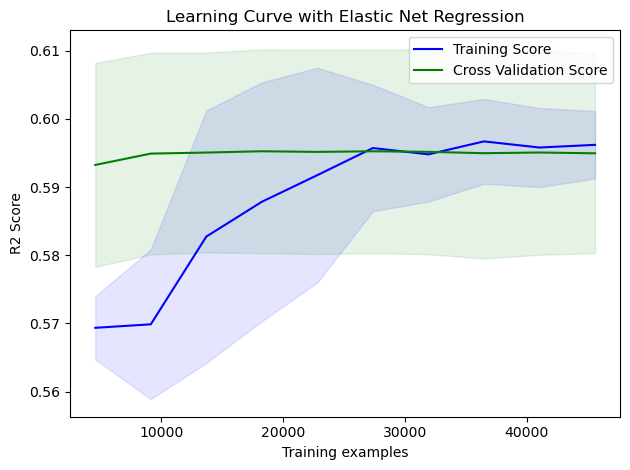

In [11]:
# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score", color='b')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='b', alpha=0.1)
plt.plot(train_sizes, val_scores_mean, label="Cross Validation Score", color='g')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color='g', alpha=0.1)

# Adding titles and labels
plt.title("Learning Curve with Elastic Net Regression")
plt.xlabel("Training examples")
plt.ylabel("R2 Score")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

R-squared on the training set: 0.5961647871118836
       actual value      predicted     difference
7625       198000.0  255210.904246  -57210.904246
75492       90000.0  196628.318758 -106628.318758
66504       39600.0   60496.634593  -20896.634593
52577      120000.0  167643.594573  -47643.594573
38830      612000.0  316755.726683  295244.273317
...             ...            ...            ...
7596       226800.0  295736.871253  -68936.871253
15640      113496.0  248879.127248 -135383.127248
6955        74400.0  226393.610863 -151993.610863
62566      210000.0  325684.002418 -115684.002418
57984      360000.0  311726.739897   48273.260103

[15208 rows x 3 columns]


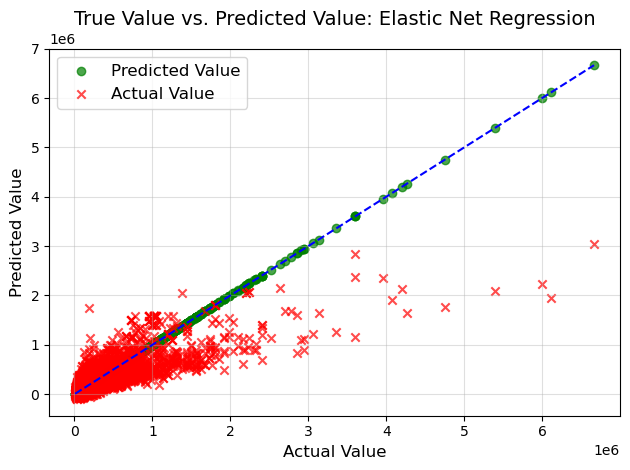

R-squared on the validation set: 0.5870171457846884


In [12]:
# Evaluate the model on the training set
train_score = reg_elasticnet.score(X_train_scaled, Y_train)
print("R-squared on the training set:", train_score)

# Predict on the test set
Y_pred = reg_elasticnet.predict(X_test_scaled)

# Create a DataFrame to compare actual and predicted values
pred_table = pd.DataFrame(data={"actual value": Y_test, "predicted": Y_pred})
pred_table["difference"] = pred_table["actual value"] - pred_table["predicted"]
print(pred_table)

# Scatter plot for Y_test (green) and Y_pred (red)
plt.scatter(Y_test, Y_test, c='green', marker='o', label='Predicted Value', alpha=0.7)
plt.scatter(Y_test, Y_pred, c='red', marker='x', label='Actual Value', alpha=0.7)

# Add labels and title
plt.xlabel("Actual Value", fontsize=12)
plt.ylabel("Predicted Value", fontsize=12)
plt.title("True Value vs. Predicted Value: Elastic Net Regression", fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Add a diagonal line (perfect prediction line)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='blue')

# Grid for better readability
plt.grid(alpha=0.4)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

# Evaluate the model on the validation set
val_score = reg_elasticnet.score(X_val_scaled, Y_val)
print("R-squared on the validation set:", val_score)